# Case Genius — Gemini Human‑in‑the‑Loop, Game‑Theoretic Analysis

Consultant-style | Ambiguity-aware | UI-driven

In [29]:
# =========================
# CELL 1: LLM + STATE (SAFE)
# =========================

import json
import time
from typing import Dict
from IPython.display import display, clear_output
import ipywidgets as widgets
import google.generativeai as genai

# 🔐 CONFIG
GEMINI_API_KEY = "KEY"
GEMINI_MODEL = "gemini-2.5-flash"

genai.configure(api_key=GEMINI_API_KEY)
_model = genai.GenerativeModel(GEMINI_MODEL)

def llm_generate(prompt: str, retries=3, wait=3) -> str:
    for i in range(retries):
        try:
            r = _model.generate_content(prompt)
            return getattr(r, "text", "") or ""
        except Exception as e:
            if "429" in str(e):
                time.sleep(wait)
            else:
                return ""
    return ""

# -------------------------
# GLOBAL STATE
# -------------------------
STATE = {
    "case": "",
    "step": 0,
    "max_steps": 8,
    "knowledge": {},
    "questions": [],
    "answers": [],
    "explanations": []
}


In [30]:
# =========================
# CELL 2: AGENT LOGIC (GUARDED)
# =========================

def fallback_question():
    return {
        "question": "What should be the primary strategic focus for this launch?",
        "why": "When information is insufficient or ambiguous, anchoring on a primary strategic focus helps constrain later decisions.",
        "options": {
            "A": "Rapid market share capture",
            "B": "Premium brand positioning",
            "C": "Cost leadership",
            "D": "Test-and-learn pilot launch"
        }
    }


def generate_next_question():
    prompt = f"""
You are a senior strategy consultant AI.

CASE:
{STATE['case']}

PREVIOUS ANSWERS:
{json.dumps(STATE['answers'], indent=2)}

KNOWN INSIGHTS:
{json.dumps(STATE['knowledge'], indent=2)}

Generate ONE MCQ decision.

Rules:
- Must depend on prior answers
- 4 options only (A–D)
- Explain why this question is being asked
- Business realism (finance / market / ops)

Return STRICT JSON:
{{
  "question": "...",
  "why": "...",
  "options": {{
    "A": "...",
    "B": "...",
    "C": "...",
    "D": "..."
  }}
}}
"""

    raw = llm_generate(prompt)

    if not raw:
        return fallback_question()

    try:
        parsed = json.loads(raw)
        if "question" in parsed and "why" in parsed and "options" in parsed:
            return parsed
        else:
            return fallback_question()
    except:
        return fallback_question()


def update_knowledge(question, answer):
    prompt = f"""
Summarize the implication of this decision in 2 bullets.

QUESTION:
{question}

ANSWER:
{answer}
"""
    insight = llm_generate(prompt)
    STATE["knowledge"][f"step_{STATE['step']}"] = insight or "No new insight extracted."


✅ CASE ANALYSIS COMPLETE



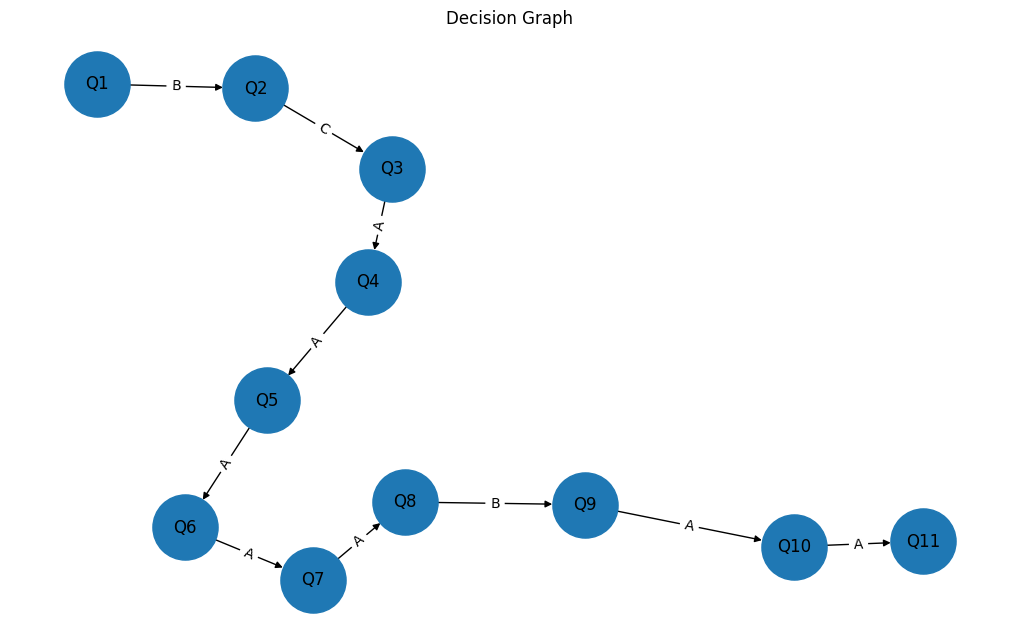

As a senior consultant, here's a summary of L'Oréal's strategic journey as outlined in the case data:

L'Oréal's strategic evolution is characterized by a deliberate series of decisions, each building upon the last, to maintain leadership in a highly fragmented and dynamic global beauty market.

### Key Decisions Taken and Their Influence:

1.  **Initial Strategic Foundation: Broad Differentiation & Multi-Brand Portfolio:**
    *   **Decision:** L'Oréal's foundational decision is to pursue **broad differentiation** through a **diverse, multi-segment, multi-brand portfolio** with **global reach and extensive local adaptation**. This allows them to cater to a wide array of consumer preferences, cultural nuances, and economic conditions.
    *   **Influence:** This strategy immediately establishes effective market penetration, relevance across varied segments, and forms the bedrock of their sustained competitive advantage by building a resilient brand ecosystem.

2.  **Addressing Internal

In [31]:
# =========================
# CELL 3: INTERACTIVE WORKFLOW + DECISION GRAPH + LOGGING (FIXED)
# =========================

import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

# -------------------------
# FILE LOGGING
# -------------------------
LOG_FILE = f"case_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

def log(text):
    with open(LOG_FILE, "a") as f:
        f.write(text + "\n")


# -------------------------
# DECISION GRAPH
# -------------------------
G = nx.DiGraph()


# -------------------------
# SAFE JSON EXTRACTION
# -------------------------
def extract_json(text: str):
    try:
        start = text.index("{")
        end = text.rindex("}") + 1
        return json.loads(text[start:end])
    except:
        return None


# -------------------------
# NON-REPEATING QUESTION GENERATOR
# -------------------------
def generate_next_question():
    asked_questions = [q["question"] for q in STATE["questions"]]

    prompt = f"""
You are a senior strategy consultant AI.

CASE:
{STATE['case']}

PRIOR QUESTIONS (DO NOT REPEAT):
{json.dumps(asked_questions, indent=2)}

PRIOR ANSWERS:
{json.dumps(STATE['answers'], indent=2)}

CURRENT KNOWLEDGE:
{json.dumps(STATE['knowledge'], indent=2)}

TASK:
Generate the NEXT most important MCQ.

Rules:
- Must NOT repeat earlier questions
- Must build on prior decisions
- Must introduce a NEW degree of freedom
- Explain why this question is asked now

Return JSON ONLY:
{{
  "question": "...",
  "why": "...",
  "intent": "market | finance | ops | risk | brand | org",
  "options": {{
    "A": "...",
    "B": "...",
    "C": "...",
    "D": "..."
  }}
}}
"""

    raw = llm_generate(prompt)
    parsed = extract_json(raw)

    if (
        parsed
        and "question" in parsed
        and parsed["question"] not in asked_questions
        and "options" in parsed
        and "why" in parsed
    ):
        return parsed

    # ---- fallback (rare, safe) ----
    return {
        "question": f"What strategic constraint should dominate step {STATE['step'] + 1}?",
        "why": "When signals are noisy, selecting a dominant constraint enables forward progress.",
        "intent": "strategy",
        "options": {
            "A": "Speed to market",
            "B": "Margin protection",
            "C": "Brand risk control",
            "D": "Learning velocity"
        }
    }


# -------------------------
# UI ELEMENTS
# -------------------------
case_input = widgets.Textarea(
    description="Case:",
    layout=widgets.Layout(width="100%", height="120px")
)

start_btn = widgets.Button(description="Start Case", button_style="success")

left_panel = widgets.VBox()
right_panel = widgets.VBox()

dashboard = widgets.HBox([
    widgets.VBox([case_input, start_btn], layout=widgets.Layout(width="35%")),
    widgets.VBox([left_panel, right_panel], layout=widgets.Layout(width="65%"))
])


# -------------------------
# RENDER STEP
# -------------------------
def render_step():
    clear_output()
    display(dashboard)

    q = STATE["questions"][-1]

    radios = widgets.RadioButtons(
        options=[(f"{k}. {v}", k) for k, v in q["options"].items()],
        layout=widgets.Layout(width="100%")
    )

    submit = widgets.Button(description="Submit Decision", button_style="primary")

    def on_submit(_):
        answer = radios.value
        STATE["answers"].append(answer)

        # ---- LOGGING ----
        log(f"\nSTEP {STATE['step'] + 1}")
        log(f"QUESTION: {q['question']}")
        log(f"ANSWER: {answer}")
        log(f"WHY ASKED: {q['why']}")

        # ---- UPDATE KNOWLEDGE ----
        update_knowledge(q["question"], answer)

        # ---- UPDATE GRAPH ----
        node_id = f"Q{STATE['step'] + 1}"
        G.add_node(node_id, label=q["intent"])
        if STATE["step"] > 0:
            G.add_edge(f"Q{STATE['step']}", node_id, decision=answer)

        STATE["step"] += 1

        if STATE["step"] < STATE["max_steps"]:
            next_q = generate_next_question()
            STATE["questions"].append(next_q)
            STATE["explanations"].append(next_q["why"])
            render_step()
        else:
            render_final()

    submit.on_click(on_submit)

    left_panel.children = [
        widgets.HTML(f"<h3>Decision {STATE['step'] + 1}</h3>"),
        widgets.HTML(f"<b>{q['question']}</b>"),
        radios,
        submit
    ]

    right_panel.children = [
        widgets.HTML("<h3>Why this question?</h3>"),
        widgets.HTML(q["why"]),
        widgets.HTML("<h4>Intent</h4>"),
        widgets.HTML(q["intent"]),
        widgets.HTML("<h3>Accumulated Knowledge</h3>"),
        widgets.HTML(f"<pre>{json.dumps(STATE['knowledge'], indent=2)}</pre>")
    ]


# -------------------------
# FINAL OUTPUT
# -------------------------
def render_final():
    clear_output()
    print("✅ CASE ANALYSIS COMPLETE\n")

    # ---- DECISION GRAPH ----
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=2200)
    edge_labels = nx.get_edge_attributes(G, 'decision')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Decision Graph")
    plt.show()

    # ---- CONSULTANT SUMMARY ----
    summary_prompt = f"""
You are a senior consultant.

Summarize this case:
- Key decisions taken
- How each decision influenced the next
- Final strategic direction

DATA:
{json.dumps(STATE, indent=2)}
"""
    summary = llm_generate(summary_prompt)
    print(summary)

    log("\nFINAL SUMMARY\n")
    log(summary)


# -------------------------
# START
# -------------------------
def on_start(_):
    STATE["case"] = case_input.value
    STATE["step"] = 0
    STATE["knowledge"] = {}
    STATE["questions"] = []
    STATE["answers"] = []
    STATE["explanations"] = []
    G.clear()

    log(f"\n\n=== NEW CASE STARTED ===\n{STATE['case']}\n")

    first_q = generate_next_question()
    STATE["questions"].append(first_q)
    STATE["explanations"].append(first_q["why"])
    render_step()

start_btn.on_click(on_start)
display(dashboard)
